<a href="https://colab.research.google.com/github/Renita1206/Bone-Fracture-Detection/blob/main/Bone%20Fracture%20Detection%20Prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries and Setting up environment

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import cv2
from os import listdir
import random

In [1]:
from google.colab.patches import cv2_imshow
from skimage import io

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import tensorflow as tf

In [5]:
import keras
from keras import optimizers
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, Flatten

In [6]:
from keras import backend as K

## Setting up dataset from Kaggle

In [7]:
! pip install --upgrade --force-reinstall --no-deps kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 3.2 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73050 sha256=710d2a334000edd7b858922669e42ca1825e516d89a49347de5d66eccb754c87
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [8]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bluecoder1206","key":"89cfc5c1eedf7d9f4e20380e8c324304"}'}

In [9]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

In [10]:
! chmod 600 ~/.kaggle/kaggle.json

In [11]:
! kaggle datasets download -d andradaolteanu/rsna-fracture-detection

100% 3.60G/3.61G [00:46<00:00, 62.1MB/s]
100% 3.61G/3.61G [00:46<00:00, 83.9MB/s]


In [ ]:
!unzip rsna-fracture-detection.zip -d dataset

## Metafile EDA

In [13]:
train = pd.read_csv('/content/dataset/train.csv')
#print(train.info())
train.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7,total_fractures
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0,2
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0,1
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0,1
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0,1


In [14]:
def get_fractured_bones(patient_id):
    fractured_bones = []
    temp = train.loc[train.StudyInstanceUID == patient_id,['C1','C2', 'C3', 'C4', 'C5', 'C6', 'C7']]
    temp = list(temp.values[0]) # there is one row per id
    for i in range(len(temp)):
        if temp[i] == 1:
            fractured_bones.append('C' + str(i+1))
    return fractured_bones

In [15]:
get_fractured_bones('1.2.826.0.1.3680043.6200')

['C1', 'C2']

In [16]:
# get fractured and unfractured ids from train
fractured_ids = list(train.loc[train['patient_overall']==1,:]['StudyInstanceUID'])
unfractured_ids = list(train.loc[train['patient_overall']==0,:]['StudyInstanceUID'])
train_ids = fractured_ids + unfractured_ids
print('Number of ids from train : ', len(train_ids))
print('Number of unfractured ids from train : ', len(unfractured_ids))
print('Number of fractured ids from train : ', len(fractured_ids))

Number of ids from train :  2019
Number of unfractured ids from train :  1058
Number of fractured ids from train :  961


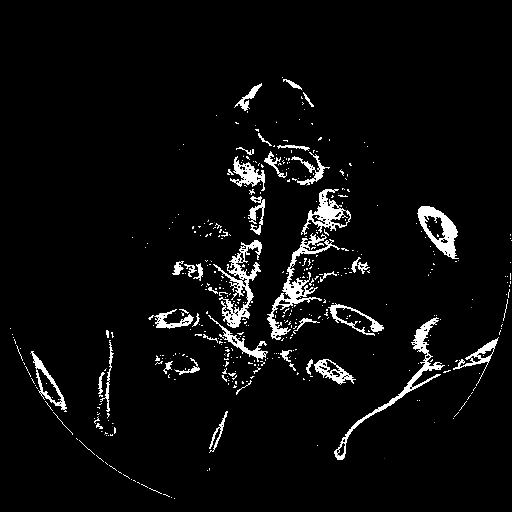

In [17]:
# path of train images /content/dataset/zip_png_images/1.2.826.0.1.3680043.10001/1.png
img = '/content/dataset/zip_png_images'
# some id
id1 = '1.2.826.0.1.3680043.6200'
# some slice of that id
slice_number = 136
# Read the file of that id and that slice number
img_path = img + '/' + id1 + '/' + str(slice_number) + '.png'
image = io.imread(img_path)
cv2_imshow(image)

In [18]:
str(get_fractured_bones(id1))

"['C1', 'C2']"

## Analysis of Scans

In [20]:
train_bb = pd.read_csv('/content/train_bounding_boxes.csv')
#train_bb.tail()

In [21]:
def plot_scans(patient_id, MAX_PLOTS = 16, plot_size = (20, 20)):
    bounding_boxes_df = train_bb.loc[(train_bb.StudyInstanceUID == patient_id) , :].head(MAX_PLOTS).reset_index() # reset_index to get indexes starting from 0
    # number of slices
    n = len(bounding_boxes_df)
    print(patient_id, n)
    if n == 0:
        return
    
    # number of rows and columns for the fig
    n_rows = int(np.sqrt(n))
    n_cols = n // n_rows
    
    if n_rows * n_cols < n:
        n_cols = n_cols + 1
        
    # define the subplots
    fig, ax = plt.subplots(n_rows, n_cols, figsize=plot_size)
    fig.suptitle('ID : '+ patient_id + ' - Fractured bones : ' + str(get_fractured_bones(patient_id)), fontsize=16)

    for row_index,row in bounding_boxes_df.iterrows():
        # Create a Rectangle patch to add later to the figure
        rect = patches.Rectangle((row.x, row.y), row.width, row.height, linewidth=2, edgecolor='r', facecolor="none") # (x, y), width, height
        # read the image
        ip = '/content/dataset/zip_png_images' + '/' + patient_id + '/' + str(row.slice_number) + '.png'
        a = io.imread(ip)
        # add the image
        i = row_index // n_cols
        j = row_index % n_cols
        ax[i, j].imshow(a, cmap=plt.cm.bone)
        # Add the boxe
        ax[i, j].add_patch(rect)
        #title
        ax[i, j].set_title('Slice : {}'.format(str(row.slice_number)), fontsize = 14)
        
    # diplay
    plt.show()

1.2.826.0.1.3680043.10678 16


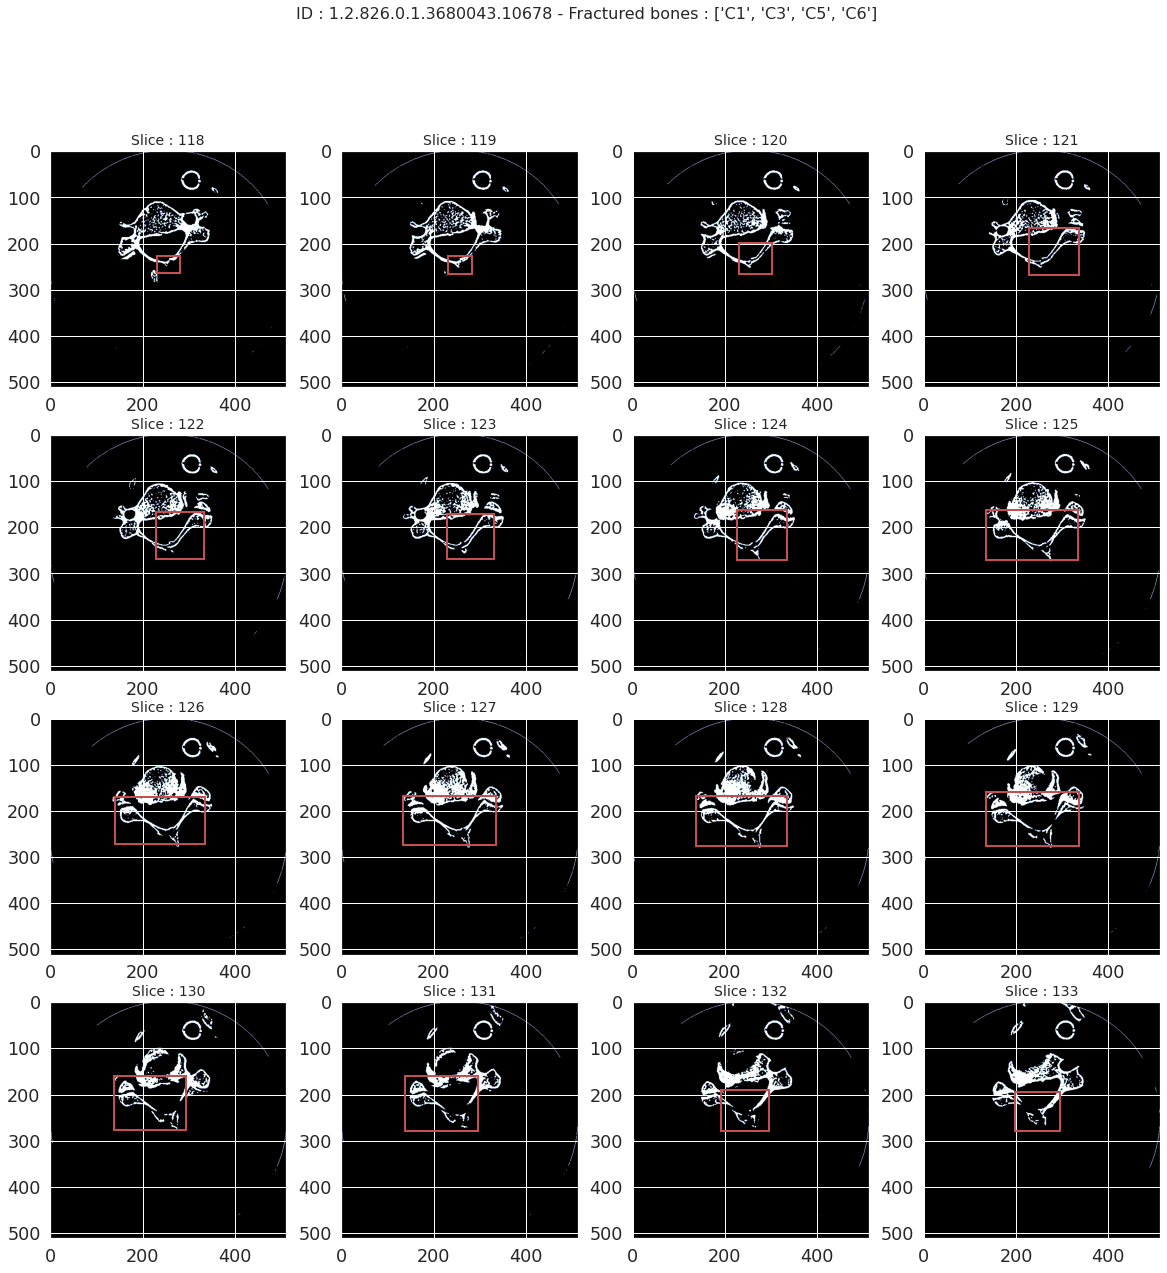

In [22]:
id_example = '1.2.826.0.1.3680043.10678'
plot_scans(id_example)

## Generate Data

In [23]:
cols = ['patient_overall', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'] # for labels
path1 = '/content/dataset/zip_png_images'

def get_data(train_df, n_ids = 500, n_img = 10, img_size = (32, 32)):
    
    train_images = []
    train_labels = []
    
    # get n_ids ids at random
    ids = random.sample(list(train_df['StudyInstanceUID'].values), n_ids)
    
    
    for id_ in ids:
        # get labels for tha id_
        labels = train_df.loc[train_df['StudyInstanceUID'] == id_, cols].values[0]
        # file names of that id_
        id_files = os.listdir(path1 + '/' + id_)
        # read each of the image files
        for i in range(min(len(id_files), n_ids)):
            img_path = img + '/' + id1 + '/' + str(slice_number) + '.png'
            image = io.imread(img_path)
            # resize image
            image = np.array(cv2.resize(image, dsize=img_size))
            # rescale image
            image = (image - image.min())/image.max()
            # add image to train_image
            train_images.append(image)
            # add labels train_labels
            train_labels.append(labels)
    return np.array(train_images), np.array(train_labels)

In [24]:
a, b = get_data(train)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(a, b, test_size=0.05, random_state=42)

## Build and train Model

In [26]:
# Define model
def r_net():
    model = Sequential()

    # 1st Convolutional Layer
    model.add(Conv2D(filters=16, input_shape=(32,32,1), kernel_size=(3,3),activation="sigmoid"))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())

    # 2nd Convolutional Layer
    model.add(Conv2D(filters=8, kernel_size=(3,3), activation="sigmoid"))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())

    # 3rd Convolutional Layer
    model.add(Conv2D(filters=4, kernel_size=(3,3), activation="sigmoid"))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    model.add(BatchNormalization())


    # Passing it to a dense layer
    model.add(Flatten())
    model.add(Dense(512, input_shape=(32*32*1,), activation="sigmoid"))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    # 2nd Dense Layer
    model.add(Dense(512, activation="sigmoid"))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    # 3rd Dense Layer
    model.add(Dense(256, activation="sigmoid"))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())

    # 4th Dense Layer
    model.add(Dense(32, activation="sigmoid"))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    # Output Layer with 8 probability classes
    model.add(Dense(8, activation="softmax"))
    return model

In [27]:
model = r_net()

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 15, 15, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 8)          0         
 2D)                                                             
                                                        

In [29]:
m = [
          #keras.metrics.TruePositives(name='tp'),
          #keras.metrics.FalsePositives(name='fp'),
          #keras.metrics.TrueNegatives(name='tn'),
          #keras.metrics.FalseNegatives(name='fn'), 
          keras.metrics.BinaryAccuracy(name='accuracy'),
          #keras.metrics.Precision(name='precision'),
          #keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc'),
          #keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
        ]

adam_opt = optimizers.Adam(learning_rate = 0.001)

In [30]:
model.compile(optimizer=adam_opt,metrics=m, loss='categorical_crossentropy')

In [31]:
history = model.fit(X_train, y_train,epochs = 3, validation_data=(X_test, y_test))

Epoch 1/3
5036/5036 [==============================] - 208s 41ms/step - loss: 1.9573 - accuracy: 0.8648 - auc: 0.7224 - val_loss: 1.9121 - val_accuracy: 0.8658 - val_auc: 0.7366
Epoch 2/3
5036/5036 [==============================] - 194s 38ms/step - loss: 1.9097 - accuracy: 0.8662 - auc: 0.7362 - val_loss: 1.9176 - val_accuracy: 0.8658 - val_auc: 0.7359
Epoch 3/3
5036/5036 [==============================] - 196s 39ms/step - loss: 1.9118 - accuracy: 0.8662 - auc: 0.7357 - val_loss: 1.9257 - val_accuracy: 0.8658 - val_auc: 0.7344


## Model Evaluation

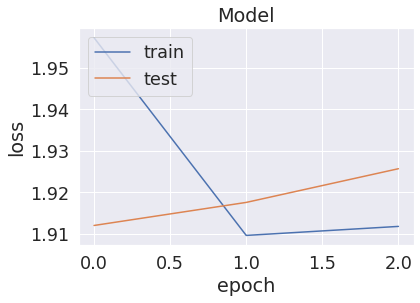

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

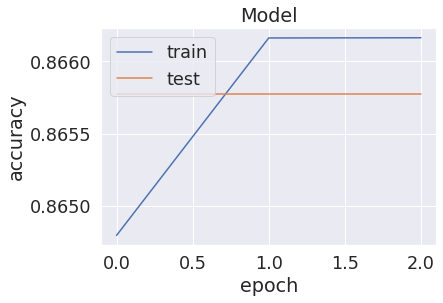

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

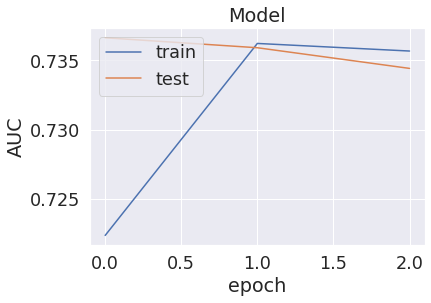

In [34]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model')
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
loss, accuracy, auc = model.evaluate(X_test, y_test, verbose=0)

In [36]:
def f1_score(precision,recall):
   return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [37]:
print("Loss: ",loss)
print("Accuracy: ",accuracy*100)
print("AUC: ",auc)

Loss:  1.9257234334945679
Accuracy:  86.57734990119934
AUC:  0.7344285249710083


## Example Output

In [61]:
test=[]

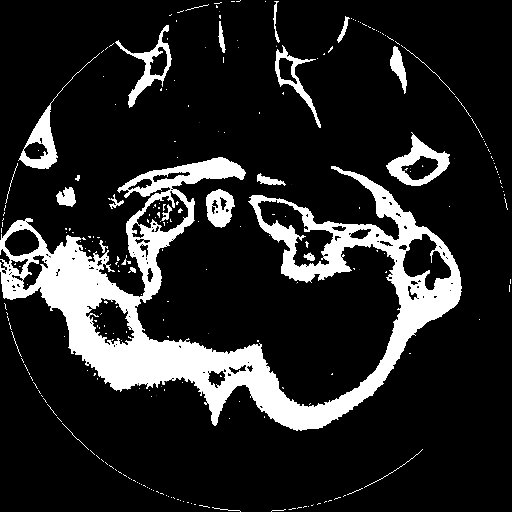

In [83]:
img_path = '/content/dataset/zip_png_images/1.2.826.0.1.3680043.4202/42.png'
image = io.imread(img_path)
cv2_imshow(image)

image = np.array(cv2.resize(image, dsize=(32,32)))
test.append(image)
t = np.array(test)

In [84]:
preds = model.predict(t)[0].tolist()
print(preds)
for i in range(len(preds)):
  if preds[i]>0.1:
    print('C'+str(i+1))

1/1 [==============================] - 0s 74ms/step
[0.422420471906662, 0.06955850124359131, 0.12272146344184875, 0.028186632320284843, 0.027183031663298607, 0.047169167548418045, 0.10475161671638489, 0.17800915241241455]
C1
C3
C7
C8


In [85]:
str(get_fractured_bones('1.2.826.0.1.3680043.4202'))

"['C1']"

In [94]:
preds = model.predict(X_test)[0].tolist()
res = []
print(preds)
for i in range(len(preds)):
  x=0
  if preds[i]>0.5:
    print('C'+str(i+1))
    x=1
  res.append(x)
print(res)
print(y_test[400])

266/266 [==============================] - 3s 12ms/step
[0.4214717447757721, 0.06975476443767548, 0.12303391098976135, 0.028170572593808174, 0.027265550568699837, 0.04722292348742485, 0.10478142648935318, 0.17829905450344086]
[0, 0, 0, 0, 0, 0, 0, 0]
[0 0 0 0 0 0 0 0]
